## In this notebook I will tests if the MCMC sampler works correctly since we are having bugs in training the model with Contrastive Divergence

In [161]:
import torch
import numpy as np
import scipy
import os
import sys



git_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/InverseFolding'
esm_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/'
git_folder_mac = '/Users/luchino_prince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/InverseFolding'
sys.path.insert(1, os.path.join(git_folder_mac, 'model'))
sys.path.insert(1, os.path.join(git_folder_mac, 'util'))


#### Code for model with PLL ########
#from potts_decoder import PottsDecoder
#### Code for model with NCE ##########
from potts_decoder import PottsDecoder
from ioutils import read_fasta, read_encodings

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.nn.functional import one_hot

from collections import defaultdict

import matplotlib.pyplot as plt

from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, collate_fn_new
from get_samples_potts import loglik_potts



## Diverge is the function that generates the new samples from the previous one:
### I copy the function here as I will simplify it to debug it more fluidly.

In [165]:
def diverge(param_embeddings, fields, sequences_original, embedding, padding_mask, steps, clone=True, progress_bar=False, return_energies=False):
        ### Sequences original: (B, M, N) I don't want the embedding.
        device = 'cpu'
        B,M,N = sequences_original.shape
        full = torch.zeros((B,M,N,steps))
        full[:, :, :, 0] = sequences_original
        ## This is important since we don't want to select padding positions due to batching.
        ## This tells me the true lenghts of the different proteins in the batch, padding is always at the the end.
        true_Ns = (N-1) - torch.sum(padding_mask, dim=1).unsqueeze(-1)
        check = torch.zeros((B, M, N))
        print(f"True Ns:{true_Ns}")
        with torch.no_grad():
            it = tqdm(range(steps)) if progress_bar else range(steps)
            ## Number of MC steps
            for step in it:
                ## I choose some random positions to update in the multiple sequence alignment. 
                ## INDS; (B, M)
                ## I need inds to be int64 due to having to use torch.scatter
                ## This formatting ensures that I never select padding positions in the MCMC procedure(padding is at the end)
                inds = torch.round(true_Ns * torch.rand((1, M), device=device)).type(torch.int64).to(device)
                llik_old = loglik_potts(param_embeddings, fields, embedding(sequences_original))
                ## Extract the old values for later: (B,M,1) --> (B,M)
                aa_old = torch.gather(sequences_original, dim=2, index=inds.unsqueeze(-1)).squeeze(1).to(device)
                
                ## Draw the next values: (B,M)
                ## Why was int32, put int64!
                aa_new = torch.randint(0, q, (B, M,), device=device).type(torch.int64)#.cuda()

                ## Create the new sequence with the changes to get the likelihoods, I overwrite to save memory.
                ## I can do this since all the necessary original information is stored in aa_old (xN times memory saving)
                check[:, :, :] = sequences_original[:, :, :]
                sequences_original.scatter_(2, inds.unsqueeze(-1), aa_new.unsqueeze(-1))
                llik_new = loglik_potts(param_embeddings, fields, embedding(sequences_original))
                
                ## Create Metropolis hasting mask to accept/reject samples and then the final values
                switch = (torch.rand((B,M), device=device) < torch.exp((llik_new-llik_old))).int()
                aa_new = (1-switch)*aa_old.squeeze(-1) + switch*aa_new

                sequences_original.scatter_(2, inds.unsqueeze(-1), aa_new.unsqueeze(-1))
                full[:, :, :, step] = sequences_original

        return sequences_original, full

#### To test it I will generate a random model in each position and then see how our sampler goes. 

In [189]:
B=1
N=3
q=21
M=6000
K=4

encodings = torch.randn((B, N, 512))
#encodings = 0.1 * torch.ones((B, N, 512))
msas = torch.randint(low=0, high=q, size=(B,M,N))

embeddings = get_embedding(q)
msas_embedded = embeddings(msas)
padding_mask = torch.zeros(size=(B, N),dtype=bool)
#padding_mask = torch.randint(low=0, high=2, size=(B,N), dtype=bool)
padding_mask_inv = (~padding_mask)


## If you put zero it is very hard to debug, with ones we can maybe spot errors
fields = torch.ones((B,N,q))
param_embeddings = torch.zeros((B,K,N,q))

## Now I test if the padding mask works. I take full padding, 
##  so regardless of fields I should generate from the random model
#fields = torch.randn((B,N,q))
#hi = -log(pi) --> possible solution

## Let us construct some ad hoc pi's

## This works for B =1
aux =torch.ones((N, q))
aux[0, :] = torch.tensor([i+1 for i in range(q)])
aux[1, :] = torch.tensor([q-i for i in range(q)])

aux = aux / torch.sum(aux, dim=-1).unsqueeze(-1)

fields[0, :, :] = -torch.log(aux)
#param_embeddings = torch.randn((B,K,N,q))
#padding_mask[0, -1] = 1
#padding_mask = torch.ones(size=(B, N),dtype=bool)



In [190]:
msas_new, mcmc_full = diverge(param_embeddings, fields, msas, embeddings, padding_mask, 1000)

True Ns:tensor([[2]])


In [191]:
msas_new.shape

torch.Size([1, 6000, 3])

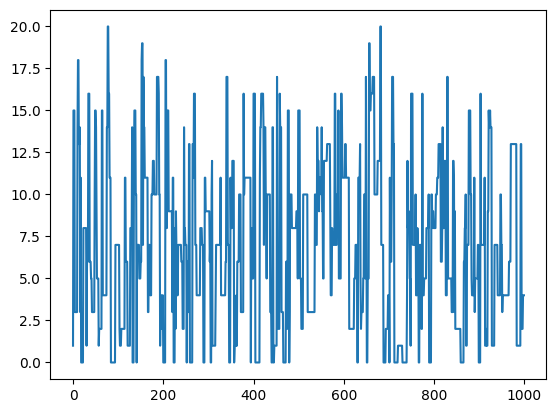

In [192]:
plt.plot(mcmc_full[0,2,-2,:])

In [193]:
msas_new_emb = embeddings(msas_new)

In [194]:
pi_n = torch.sum(msas_new_emb, dim=1)/M
pi_n.shape

torch.Size([1, 3, 21])

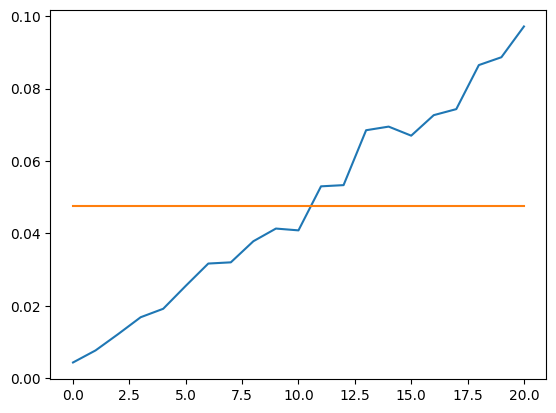

In [195]:
plt.plot(pi_n[0,0,:])
plt.plot(range(0,q), (q)*[1/q])

In [124]:
fields

tensor([[[0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476,
          0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476, 0.0476,
          0.0476, 0.0476, 0.0476, 0.0476, 0.0476],
         [0.0043, 0.0087, 0.0130, 0.0173, 0.0216, 0.0260, 0.0303, 0.0346,
          0.0390, 0.0433, 0.0476, 0.0519, 0.0563, 0.0606, 0.0649, 0.0693,
          0.0736, 0.0779, 0.0823, 0.0866, 0.0909],
         [0.0909, 0.0866, 0.0823, 0.0779, 0.0736, 0.0693, 0.0649, 0.0606,
          0.0563, 0.0519, 0.0476, 0.0433, 0.0390, 0.0346, 0.0303, 0.0260,
          0.0216, 0.0173, 0.0130, 0.0087, 0.0043]]])